###  *Authors*
1. *Kajetan Bochajczuk*
2. *Adam Bruder*
3. *Ewelina Janowska*

### *Techincal note*
- ***Equation numbering*** *is not implemented as it requires special notebook extension and we would like as little efford as possible from final user.*
- ***Interactive 3D plot*** *are not interactive, because there is a bug with switching betwen static and interactive mode (```%matplotlib notebook``` turns on interactive graphs, but after switching back to ```%matplotlib inline``` it stops working).*
- *Many lines of code are needed for creating appealing graphs and those cells could be hidden but this also requires special extension.*

***We hope that those shortcomings won't cause to much inconvenience.***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from mpl_toolkits import mplot3d
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 8]  # Just to make the plots bigger.
%matplotlib inline

<a id='toc'></a>


# Table of contents
1. <a href='#fem_pde'>Finite element method for parabolic partial differential equations</a>
    1. <a href='#triangulation'>Triangulation</a>
    2. <a href='#numerical_solution'>Numerical solution</a>
    3. <a href='#solution_ode'>Solution to system of ODE's</a>
2. <a href='#examples'>Examples</a>
    1. <a href='#example_1'>Example 1: Heat equation with point-like initial condition</a>
    2. <a href='#example_2'>Example 2: Nonhomogeneous heat equation</a>
3. <a href='#convergence'>Convergence</a>
4. <a href='#conclusion'>Conclusion</a>
5. <a href='#bibliography'>Bibliography</a>

<a id='fem_pde'></a>

# Finite element method for parabolic partial differential equations
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

Let's consider following parabolic partial differential equation with homogeneous boundary conditions. The goal is to find function $u \colon [0, T] \times [0, L] \mapsto \mathrm{I}\!
\mathrm{R}$ such that
$$
\left\{
    \begin{align}
        & u_t(t, x) - u_{xx}(t, x) + cu(t, x) = f(t, x), & (t, x) \in [0, T] \times [0, L]\\
        & u(t, 0) = u(t, L) \equiv 0, & t \in [0, T]\\
        & u(0, x) = u_0(x), & x \in [0, L]\\
    \end{align}
\right.
$$
for given continuous function $f\colon [0, T] \times [0, L] \mapsto \mathrm{I}\!\mathrm{R}$, continuous function $u_0 \colon [0, L] \mapsto \mathrm{I}\!\mathrm{R}$ and nonnegative constant $c$.

In [2]:
# Parameters
C = 1
T = 5
L = 2 * np.pi

In [3]:
# Domain
NUM_SAMPLES = 1000
x = np.linspace(0, L, num=NUM_SAMPLES)
t = np.linspace(0, T, num=NUM_SAMPLES)

In [4]:
# f function
def f(t, x):
    return np.exp(-t) * np.sin(x)

Let's introduce test function $\phi(x) \in \mathcal C_0^\infty([0, L])$ (absolutely smooth and vanishing at the ends of the interval). Multiplying both sides of previous equation by it gives us
$$
u_t(t, x)\phi(x) - u_{xx}(t, x)\phi(x) + cu(t, x)\phi(x) = f(t, x)\phi(x) \qquad \forall \phi \in \mathcal C_0^\infty([0, L])
$$
We can then itegrate on $[0, L]$ interval obtaining
$$
\int_0^L u_t(t, x)\phi(x) dx - \int_0^L u_{xx}(t, x)\phi(x) dx + c \int_0^L u(t, x)\phi(x) dx = \int_0^L f(t, x)\phi(x) dx \qquad \forall \phi \in \mathcal C_0^\infty([0, L])
$$
Using integration by parts in the second term of the sum we obtain
$$
\int_0^L u_t(t, x)\phi(x) dx + \int_0^L u_x(t, x)\phi_x(x) dx + c \int_0^L u(t, x)\phi(x) dx = \int_0^L f(t, x)\phi(x) dx \qquad \forall \phi \in \mathcal C_0^\infty([0, L])
$$
We have to remeber that the initial condition changes acordingly. 
$$
\int_0^L u(0, x)\phi(x) dx = \int_0^L u_0(x) \phi(x) dx \qquad \forall \phi \in \mathcal C_0^\infty([0, L])
$$
To simplify the notation we will introduce a scalar product $\langle w, v \rangle = \int_0^L w(x)v(x) dx$. We can then rewrite aforementioned equation as
$$
\langle u_t(t, \cdot), \phi \rangle + \langle u_x(t, \cdot), \phi_x \rangle + c \langle u(t, \cdot), \phi \rangle = \langle f(t, \cdot), \phi \rangle \qquad \forall \phi \in \mathcal C_0^\infty([0, L])
$$
with initial condition $\langle u_0, \phi \rangle$.

Recalling Leibniz integral rule we can move the $\frac{\partial}{\partial t}$ derivative in front of the integral (and changing the notation to be more consistent) we get
$$
\frac{d}{dt} \langle u(t, \cdot), \phi \rangle + \langle \frac{\partial}{\partial x} u(t, \cdot), \frac{d}{dx} \phi \rangle + c \langle u(t, \cdot), \phi \rangle = \langle f(t, \cdot), \phi \rangle  \qquad \forall \phi \in \mathcal C_0^\infty([0, L])
$$

<a id='triangulation'></a>

## Triangulation
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

Let us introduce an uniform triangulation (division) of the $[0, L]$ interval into subintervals $T_h([0, L]) = \{ [x_k, x_{k+1}] \}_{k=0}^{N-1}$ where $0 = x_0 < \dots < x_{N-1} = L$ and $h = \frac LN$.

In [5]:
NUM_PTS = 20
triangulation_pts = np.linspace(0, L, NUM_PTS)

Based on this triangulation we can introduce $V^h$ - discrite space of continuous, linear on intervals functions vanishing at the ends of $[0, L]$ interval.

Let us now introduce so called nodal functions $v_k \in V^h$ for $k = 1, \dots, N-1$ such that $v_k(x_k) = 1$ and $v_k(x_j) = 0$ for $j \ne k$. Example of such functions would be **hat functions** defined and shown below.

In [6]:
def hat_function(x: np.ndarray, left: float, right: float, middle: float = None) -> np.ndarray:
    if left > right:
        raise ValueError("Left point cannot be greater than right one.")
    if middle is None:  # By default middle point is created in equal distance from left to right.
        middle = left + (right - left) / 2
    if not left <= middle <= right:
        raise ValueError("Middle point must be between {left} and {right}.")
    ans = np.copy(x)
    ans[(x <= left) | (right <= x)] = 0.0
    ans[(left < x) & (x <= middle)] = (x[(left < x) & (x <= middle)] - left) / (middle - left)
    ans[(middle < x) & (x <= right)] = (right - x[(middle < x) & (x <= right)]) / (right - middle)
    return ans

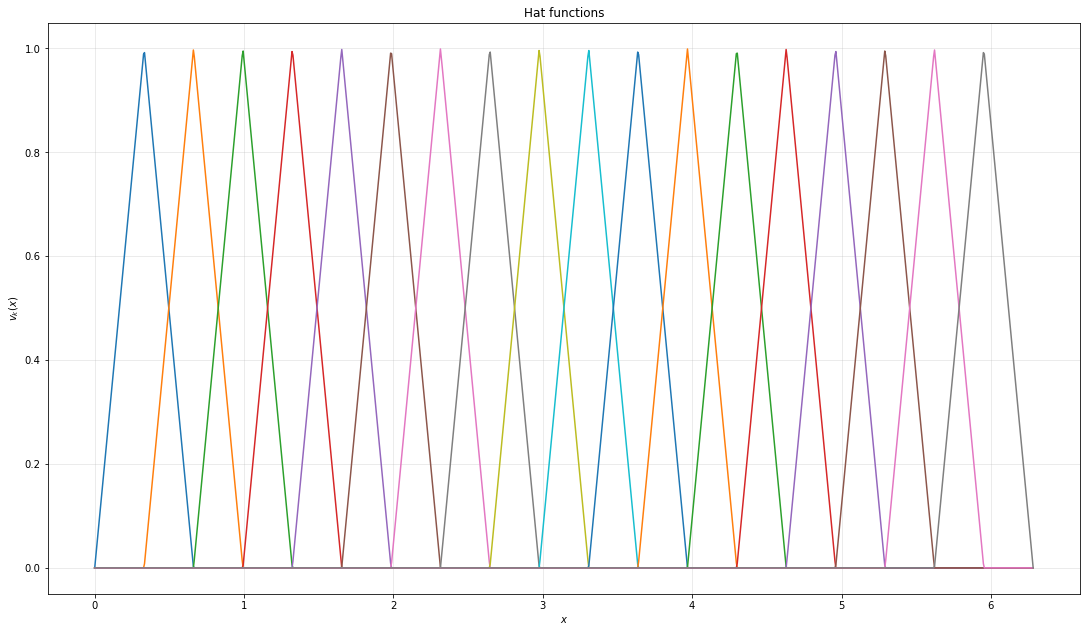

In [7]:
base_functions = []
plt.gcf().set_size_inches(18.5, 10.5, forward=True)
for i in range(1, len(triangulation_pts) - 1):
    func = hat_function(x, triangulation_pts[i - 1], triangulation_pts[i + 1])
    base_functions.append(func)
    plt.plot(x, func)
plt.xlabel(r'$x$')
plt.ylabel(r'$v_k(x)$')
plt.title('Hat functions')
plt.grid(alpha=0.3)

Functions $v_k$ form a base of the $V^h$ space (see e.g. [Marcinowski L. *Numeryczne rozwiązywanie równań różniczkowych*](http://mst.mimuw.edu.pl/wyklady/nrr/wyklad.pdf)) such that for each function $g \in V^h$ we have
$$
g(x) = \sum_{i=1}^{N-1}u(x_i)v_i(x).
$$

Equiped with the above space we can restate previous weak formulation into finding function $u_h \in V^h$ (approximation of $u$) such that for all $v_k \in V^h$ we have
$$
\frac{d}{dt} \langle u_h(t, \cdot), v_k \rangle + \langle \frac{\partial}{\partial x} u_h(t, \cdot), \frac{d}{dx} v_k \rangle + c \langle u_h(t, \cdot), v_k \rangle = \langle f(t, \cdot), v_k \rangle
$$
with initial condition $\langle u_h(0, \cdot), v_h \rangle = \langle u_0, v_h \rangle$.

Substituting now $u_h(t, x) = \sum_{i=1}^{N-1} u(t, x_i)v_i(x)$ we obtain
$$
\sum_{i=1}^{N-1} \frac{d}{dt} u(t, x_i) \langle v_i, v_k \rangle +
\sum_{i=1}^{N-1} u(t, x_i)\langle \frac{d}{dx} v_i, \frac{d}{dx} v_k \rangle +
c \sum_{i=1}^{N-1} u(t, x_i) \langle v_i, v_k \rangle = \langle f(t, \cdot), v_k \rangle
$$

We can write in in matrix form
$$
\mathbf{M}_h \frac{d}{dt}\overline u(t) + \left(\mathbf{A}_h + c \mathbf{M}_h \right)\overline u(t) = \overline f(t)
$$
with initial condition $\overline u_0$. Where 
\begin{align}
\mathbf M_h &= \left\{ \left\langle v_k(x), v_l(x) \right\rangle \right\}_{k,l = 1}^{N - 1} =
\left\{ \int_a^b v_k(x) v_l(x) dx \right\}_{k, i = 1}^{N - 1}
\\
\mathbf A_h &= \left\{ \left\langle \frac{d}{dx}v_k(x), \frac{d}{dx}v_l(x) \right\rangle \right\}_{k,l = 1}^{N - 1} =
\left\{ \int_a^b \frac{d}{dx}v_k(x) \frac{d}{dx}v_l(x) dx \right\}_{k,i = 1}^{N - 1}
\\
\mathbf u(t) &= \left[ u(t, x_1), \dots, u(t, x_{N-1}) \right] ^ \top  \\
\mathbf u_0 &= \mathbf M_h ^ {-1} \left[ \left\langle u(0, x), v_1(x) \right\rangle, \dots, \left\langle u(0, x), v_{N-1}(x) \right\rangle \right] ^ \top \\
\mathbf f(t) &= \left[ \left\langle f(t, x), v_1(x) \right\rangle, \dots, \left\langle f(t, x), v_{N-1}(x) \right\rangle \right] ^ \top
\end{align}

Multiplying both sides by $\mathbf{M}_h^{-1}$ we obtain 
$$
\frac{d}{dt}\mathbf u(t) + \left( \mathbf{M}_h^{-1} \mathbf{A}_h + c \mathbf{I} \right)\mathbf u(t) =
\mathbf{M}_h^{-1} \mathbf f(t)
$$
So we are dealing with a set of $N-1$ linear ordinary nonhomogeneous differential equations of first order. We can solve it easily using one of the numerical solvers (keeping in mind that this equation is **stiff** se we should use an appropriate method).

<a id='numerical_solution'></a>

## Numerical solution
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

Together with already created base functions we need their derivatives for calculating the $\mathbf A_h$ matrix.

In [8]:
x_derivatives = np.linspace(0, L, num=NUM_SAMPLES - 1)  # Domain for derivatives (numerical necessities)
base_functions_derivatives = [np.diff(fnc) / np.diff(x) for fnc in base_functions]

For the creation of the $\mathbf M_h$ and $\mathbf A_h$ matrix we will use numerical integration (for details see [numpy.trapz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.trapz.html)).

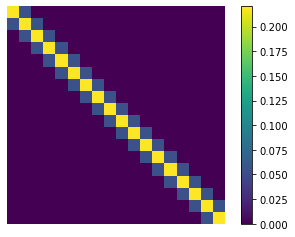

In [9]:
M = np.array([[np.trapz(f1 * f2, x) for f1 in base_functions] for f2 in base_functions])
plt.imshow(M, interpolation='none'); 
plt.colorbar(); plt.gca().set_axis_off()

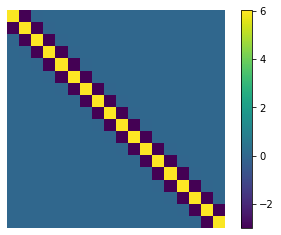

In [10]:
A = np.array([[np.trapz(f1 * f2, x_derivatives) for f1 in base_functions_derivatives] 
              for f2 in base_functions_derivatives])
plt.imshow(A, interpolation='none'); plt.colorbar(); plt.gca().set_axis_off()

We need to also define the initial condition $\mathbf u_0$ vector.

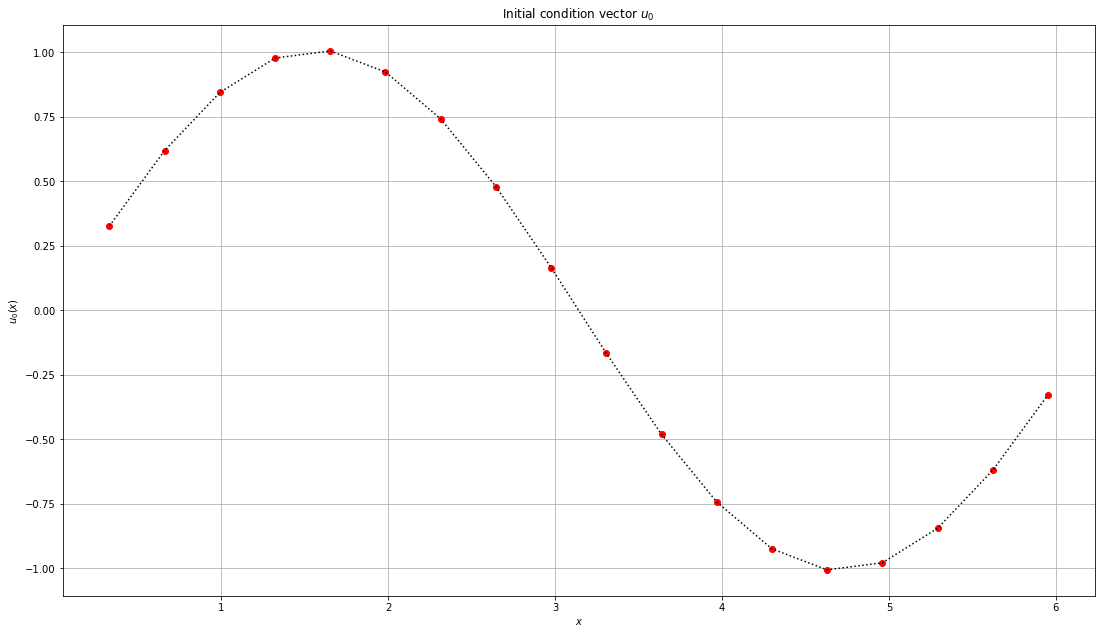

In [11]:
u0 = np.dot(np.linalg.inv(M), [np.trapz(np.sin(x) * bf, x) for bf in base_functions])
plt.gcf().set_size_inches(18.5, 10.5, forward=True)
plt.plot(triangulation_pts[1:-1], u0, 'ro')
plt.plot(triangulation_pts[1:-1], u0, 'k:')
plt.ylabel('$u_0(x)$')
plt.xlabel('$x$')
plt.title(r'Initial condition vector $u_0$')
plt.grid()

Lastly we need the $\mathbf f(t)$ function. (Not to be mistaken with the $f$ function we have defined previously for the continuous problem!)

In [12]:
def f_vec(t):
    return np.array([np.trapz(f(t, x) * bf, x) for bf in base_functions])

<a id='solution_ode'></a>

## Solution to system of ODE's
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

With all the data needed we will use function [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to solve the system of ODEs.

We have to define the right hand side of the differential equation.

In [13]:
# For efficiency it is much better to invert M matrix once and save it as a global variable 
M_inv = np.linalg.inv(M)

In [14]:
def ode_rhs(t, u):
    return np.dot(M_inv, f_vec(t)) - np.dot(np.dot(M_inv, A) + C * np.identity(len(M)), u)

Then we can simply obtain the solution.

In [15]:
solution = scipy.integrate.solve_ivp(ode_rhs, t_span=(min(t), max(t)), y0=u0, method="BDF", t_eval=t)

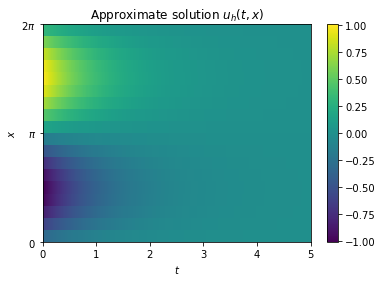

In [16]:
plt.imshow(solution.y, interpolation='none', aspect='auto', extent=[min(t), max(t), min(x), max(x)])
plt.colorbar(orientation='vertical')
plt.gca().set_yticks([0, np.pi, 2 * np.pi])
plt.gca().set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Approximate solution $u_h(t, x)$')
plt.show()

In the above, two-dimensional picture, we can see clearly the smoothing as the equation approaches steady state. 

In addition to that picture it is useful to see the approximate solution in three dimensions. On the next plot, black lines show on which lines solution to the previous set of ODE's is given (resembling clearly the method of characteristics).

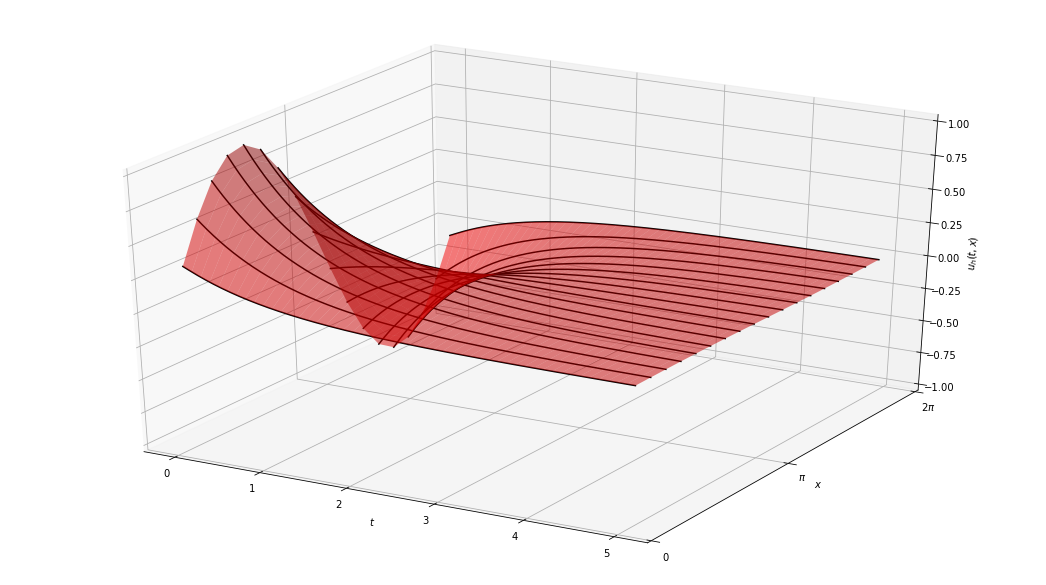

In [17]:
ts, xs = np.meshgrid(t, triangulation_pts[1: -1])
# %matplotlib notebook
ax = plt.figure().gca(projection="3d")
plt.gcf().set_size_inches(18.5, 10.5, forward=True)
ax.plot_surface(ts, xs, solution.y, color='r', alpha=0.5)
for i, init_pt in zip(range(solution.y.shape[0]), triangulation_pts[1:-1]):
    ax.plot(t, np.repeat(init_pt, len(t)), solution.y[i], color='k', markersize=10)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_yticks([0, np.pi, 2 * np.pi])
ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
ax.set_zlabel('$u_h(t, x)$')
plt.show()

<a id='examples'></a>

# Examples
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

To show more examples it would be very convienient to wrap all of the above steps into single function solving parabolic partial differential equation using finite element method.

In [18]:
def fem_parabolic_pde(t, x, c=0,
                      initial_func=lambda x: np.repeat(0.0, len(x)),
                      f=lambda _t, _x: np.repeat(0.0, max(len(t), len(x))), 
                      num_hats=20):
    triangulation_pts = np.linspace(min(x), max(x), num_hats)
    base_functions = []
    for i in range(1, len(triangulation_pts) - 1):
        base_functions.append(hat_function(x, triangulation_pts[i - 1], triangulation_pts[i + 1]))
    x_derivatives = np.linspace(min(x), max(x), num=len(x) - 1)
    base_functions_derivatives = [np.diff(fnc) / np.diff(x) for fnc in base_functions]
    M = np.array([[np.trapz(f1 * f2, x) for f1 in base_functions] for f2 in base_functions])
    A = np.array([[np.trapz(f1 * f2, x_derivatives) for f1 in base_functions_derivatives] 
                  for f2 in base_functions_derivatives])
    u0 = np.dot(np.linalg.inv(M), [np.trapz(initial_func(x) * bf, x) for bf in base_functions])
    
    def f_vec(t):
        return np.array([np.trapz(f(t, x) * bf, x) for bf in base_functions])
    
    M_inv = np.linalg.inv(M)
    
    def ode_rhs(t, u):
        return np.dot(M_inv, f_vec(t)) - np.dot(np.dot(M_inv, A) + c * np.identity(len(M)), u)
    
    solution = scipy.integrate.solve_ivp(ode_rhs, t_span=(min(t), max(t)), y0=u0, method="BDF", t_eval=t)
    return solution.y

Let us also create a helper function for making the resulting plots more appealing.

In [19]:
def plot_3d_solution(t, x, z, color='r'):
    ts, xs = np.meshgrid(t, np.linspace(min(x), max(x), len(z[:, 0])))
    ax = plt.gcf().gca(projection="3d")
    plt.gcf().set_size_inches(18.5, 10.5, forward=True)
    ax.plot_surface(ts, xs, z, color=color, alpha=0.75)
    for i, init_pt in zip(range(z.shape[0]), np.linspace(min(x), max(x), len(z[:, 0]))):
        ax.plot(t, np.repeat(init_pt, len(t)), z[i], color='k', markersize=10)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_zlabel('$u_h(t, x)$')
    plt.show()

<a id='example_1'></a>

## Example 1: Heat equation with point-like initial condition
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

As an interesting example we can consider homogeneous heat equation with point-like initial condition (because of finite nature of underlying computer it is obviously only an approximation). Thus, we will be dealing with a problem of a form:
$$
\left\{
    \begin{align}
        & u_t(t, x) - u_{xx}(t, x) = 0, & (t, x) \in [0, 10^{-2}] \times [0, 1]\\
        & u(t, 0) = u(t, L) \equiv 0, & t \in [0, 10^{-2}]\\
        & u(0, x) = \chi_{\{|x - 0,5| < 10^{-2}\}}, & x \in [0, 1]\\
    \end{align}
\right.
$$
where $\chi(x)$ is an indicator function.

Worth mentioning is the behaviour in initial times. Near the discontinuity points can obvserve "oscillations" characteristic to function approximation by finite Fourier series.

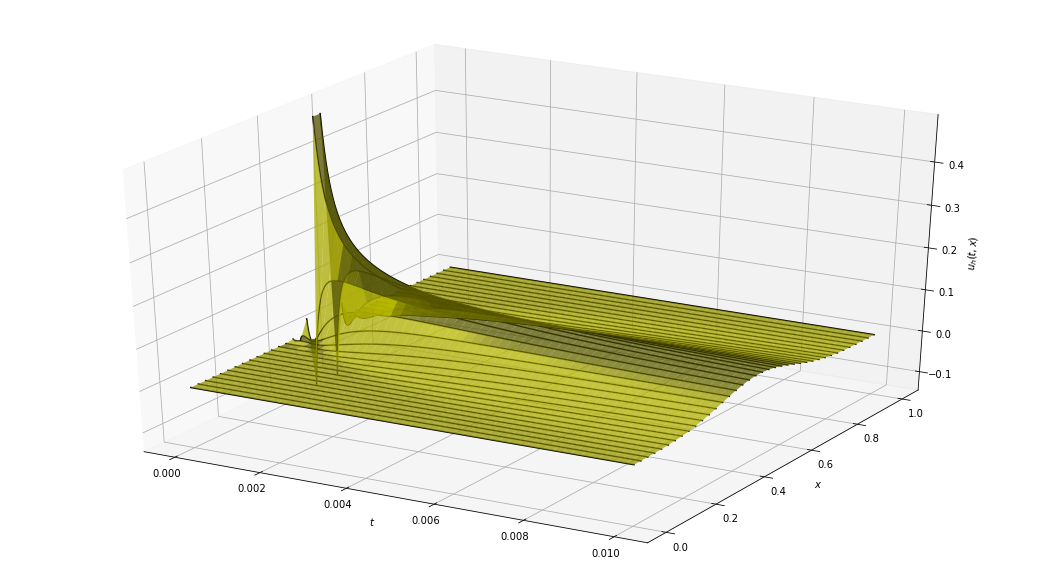

In [20]:
t = np.linspace(0, 0.01, 1000)
x = np.linspace(0, 1, 1000)
u0 = lambda x: 1 if abs(x - 0.5) < 10 ** -2 else 0
u0 = np.vectorize(u0)
solution = fem_parabolic_pde(t, x, initial_func=u0, num_hats=40)
plot_3d_solution(t, x, solution, color='y')

<a id='example_2'></a>

## Example 2: Nonhomogeneous heat equation
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

Next, let's consider nonhomogeneous heat equation:
$$
\left\{
    \begin{align}
        & u_t(t, x) - u_{xx}(t, x) = \sin^2(x), & (t, x) \in [0, 3] \times [0, 2\pi]\\
        & u(t, 0) = u(t, L) \equiv 0, & t \in [0, 3]\\
        & u(0, x) = \sin^2(x), & x \in [0, 2\pi]\\
    \end{align}
\right.
$$

Here, expected but still interesting, observation is that over time each individual heat source becomes less distinguishable.

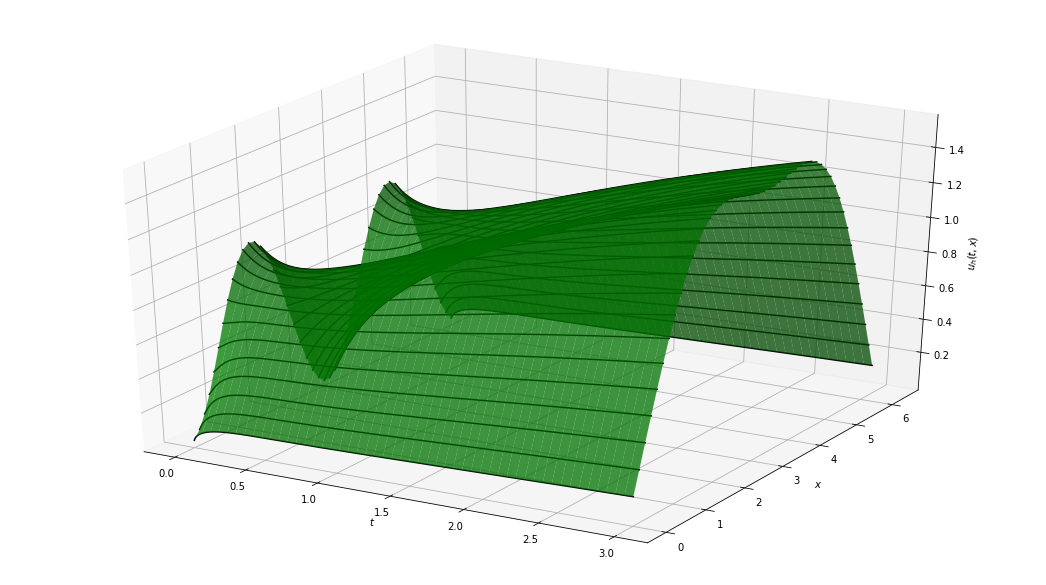

In [21]:
t = np.linspace(0, 3, 1000)
x = np.linspace(0, 2 * np.pi, 1000)
f = lambda t, x: np.sin(x) ** 2
u0 = lambda x: f(0, x)
solution = fem_parabolic_pde(t, x, initial_func=u0, f=f, num_hats=50)
plot_3d_solution(t, x, solution, color='g')

<a id='convergence'></a>

# Convergence
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

To analyze the error of the approximation $u_h$ to the true solution $u^\star$ we have to do in in some norm. Easiest one to consider is the supremum norm, i. e.
$$
e_h = \lVert u^\star - u_h \rVert = \sup_{t, x} \left|\ u^\star - u_h \right|
$$

To analyze the error numericaly let's return to our first equation, i.e.
$$
\left\{
    \begin{align}
        & u_t(t, x) - u_{xx}(t, x) + u(t, x) = e^{-t}\sin(x), & (t, x) \in [0, 5] \times [0, 2\pi]\\
        & u(t, 0) = u(t, 5) \equiv 0, & t \in [0, 5]\\
        & u(0, x) = u_0(x), & x \in [0, 2\pi]\\
    \end{align}
\right.
$$
Solution to this equation is the same as the inductuing force, i. e. $u(t, x) = e^{-t}\sin(x)$ (it can be check by simply plugging the answer into the equation).

Thus, our true solution, to which we will compare our results, is equal $u^\star(t, x) = e^{-t}\sin(x)$.

In [22]:
def u_star(t, x):
    return np.exp(-t) * np.sin(x)

Below we can see the difference between $u_h(t, x)$ calculated using $25$ base functions and $u^\star(t, x)$.

*(Feel free to change the number of nodes to see the difference in approximation).*

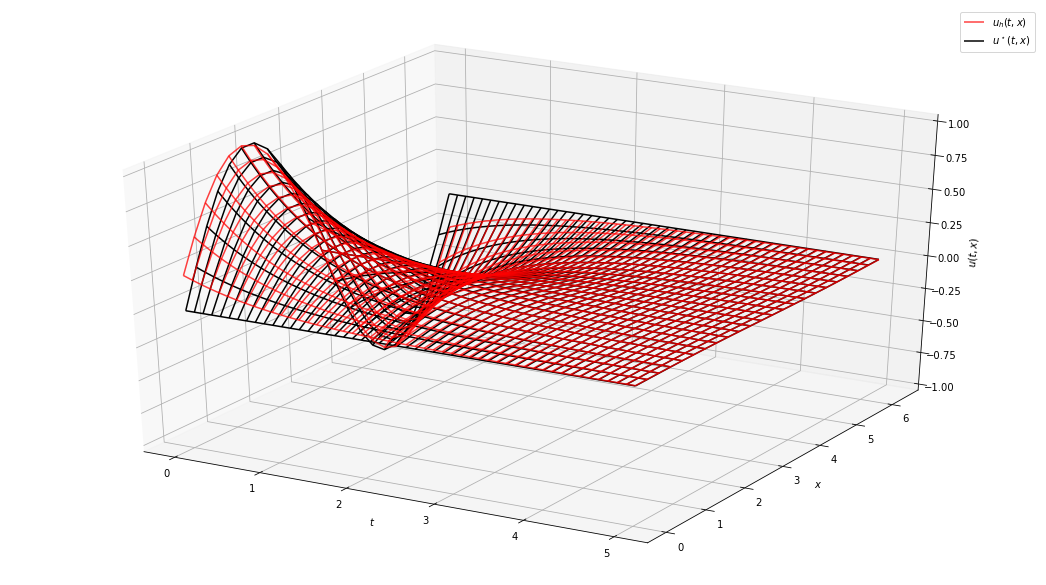

In [23]:
t = np.linspace(0, T, 1000)
x = np.linspace(0, L, 1000)
f = lambda t, x: np.exp(-t) * np.sin(x)
u0 = lambda x: np.sin(x)
solution = fem_parabolic_pde(t, x, c=1, initial_func=u0, f=f, num_hats=25)
# Plotting settings
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
ax = fig.gca(projection="3d")

# Plotting the approximate solution
ts, xs = np.meshgrid(t, np.linspace(min(x), max(x), len(solution[:, 0])))
ax.plot_wireframe(ts, xs, solution, color='r', alpha=0.75, label='$u_h(t, x)$')

# Plotting the original function u_star
ax.plot_wireframe(ts, xs, u_star(ts, xs), label='$u^\star(t, x)$', color='k')

# Plotting settings
plt.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t, x)$')
plt.show()

Thus we can calculate the supremum norm (which in finite term translates to simply calculating the maximum).

In [24]:
err = np.max(np.abs(solution - u_star(ts, xs)))
err

0.26030096978478595

We can also check the error in the $L^2$ norm, i. e.
$$
e_h = \lVert u_h - u^\star \rVert = \left( \int_0^L \!\! \int_0^T (u_h - u^\star)^2 dxdt \right) ^ {1/2}
$$

Let's create appropriate function

In [25]:
def l2_err(approx, solution, t, x):
    return (np.trapz(np.trapz((approx - solution) ** 2, x, axis=0), t)) ** (1 / 2)

Now the error is equal:

In [26]:
err = l2_err(solution, u_star(ts, xs), t, xs[:, 0])
err

0.1967064300414633

Lastly we will calculate the errors as a function of number of base funcions.

In [27]:
errors_sup = []
errors_l2 = []
for n_base_func in np.arange(5, 50):
    solution = fem_parabolic_pde(t, x, initial_func=u0, f=f, num_hats=n_base_func)
    ts, xs = np.meshgrid(t, np.linspace(min(x), max(x), len(solution[:, 0])))
    errors_sup.append(np.max(np.abs(solution - u_star(ts, xs))))
    errors_l2.append(l2_err(solution, u_star(ts, xs), t, xs[:, 0]))

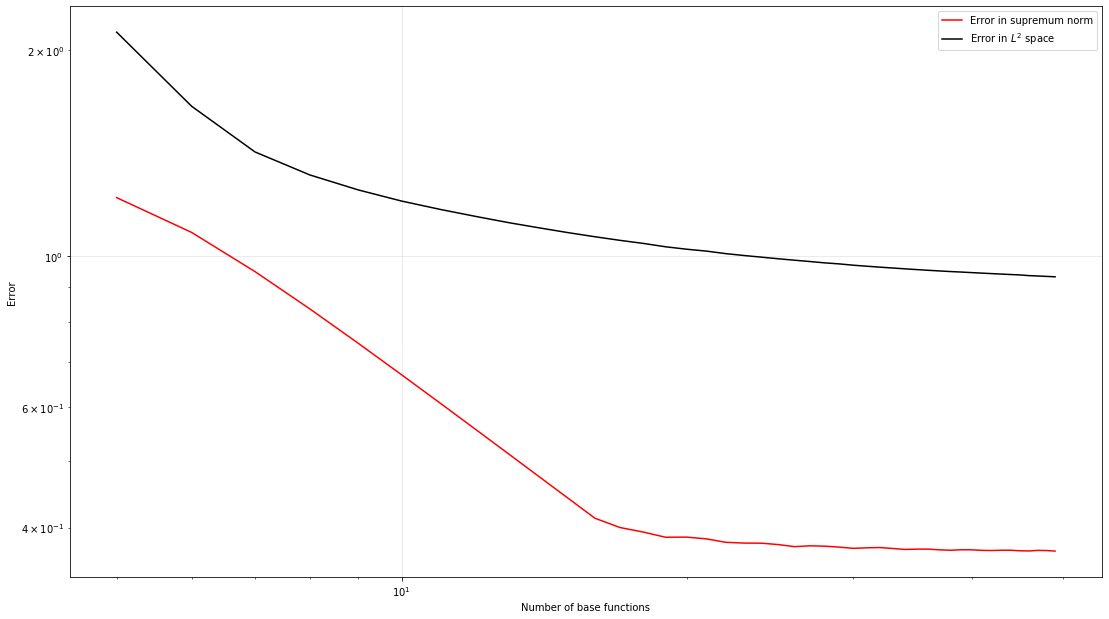

In [28]:
plt.gcf().set_size_inches(18.5, 10.5, forward=True)
plt.loglog(np.arange(5, 50), errors_sup, color='r', label='Error in supremum norm')
plt.loglog(np.arange(5, 50), errors_l2, color='k', label='Error in $L^2$ space')
plt.xlabel(r"Number of base functions")
plt.ylabel(r"Error")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

<a id='conclusion'></a>

# Conclusion
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

As we saw, finite element method solves arbitrary parabolic partial differential equation. It is based on choosing appropriate base function, then transforming the equation into the weak (integral) form. Afterwards we look for an approximate solution in finite dimensional space thus transforming PDE into set of ODEs. We can solve this system numerically and then combine the results to finally obtain approximate answer to the initial problem.

<a id='bibliography'></a>

# Bibliography
<div align='right'>
    <a href='#toc'>
        <i>Go back to table of contents</i>
    </a>
</div>

1. Leszek Marcinkowski, *Numeryczne rozwiązywanie równań różniczkowych*, http://mst.mimuw.edu.pl/, Uniwersytet Warszawski, 2011
2. Masatake Mori, *Stability and Convergence of a Finite Element Method for Solving the Stefan Problem*, Publ. RIMS, Kyoto University, 1976